# Introduction

In this notebook, we look at the data used to create the *apo*-*holo* comparisons, generating plots and summary statistics.

In [1]:
import os
import subprocess
import tempfile

import logomaker
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import openchord
import pandas as pd
from IPython.display import display, Markdown
from pyxdameraulevenshtein import damerau_levenshtein_distance

from tcr_pmhc_interface_analysis.utils import mhc_slug_to_code

In [2]:
apo_holo_summary = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')
apo_holo_summary

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
2,1bii_A-B-P_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
3,1ddh_A-B-P_pmhc.pdb,1ddh,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
4,1duz_A-B-C_pmhc.pdb,1duz,pmhc,apo,NaN,NaN,C,A,B,NaN,LLFGYPVYV,hla_a_02_01
...,...,...,...,...,...,...,...,...,...,...,...,...
353,8gon_D-E-C-A-B_tcr_pmhc.pdb,8gon,tcr_pmhc,holo,D,E,C,A,B,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
354,8gop_A-B_tcr.pdb,8gop,tcr,apo,A,B,NaN,NaN,NaN,TSESDYY-QEAYKQQN-ASSGNTPLV-SGHNS-FNNNVP-ASTWGR...,NaN,NaN
355,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02
356,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02


# Summary Numbers

In [3]:
num_entries = len(apo_holo_summary)
num_pdb_ids = len(apo_holo_summary['pdb_id'].unique())

print('There are', num_entries, 'entries in the dataset spread across', num_pdb_ids, 'PDB structures.')

There are 358 entries in the dataset spread across 255 PDB structures.


In [4]:
def both_apo_holo(group: pd.DataFrame, structure_type: str) -> bool:
    apo_structures = group.query("state == 'apo' and structure_type == @structure_type")
    holo_structures = group.query("state == 'holo'")

    return len(apo_structures) >= 1 and len(holo_structures) >= 1

In [5]:
both_apo_holo_tcrs = apo_holo_summary.groupby('cdr_sequences_collated').apply(lambda group: both_apo_holo(group, 'tcr'))
apo_holo_tcrs = both_apo_holo_tcrs.index[both_apo_holo_tcrs].tolist()

num_unique_tcrs = len(apo_holo_tcrs)

display(Markdown((f'There are {num_unique_tcrs} TCRs with both *apo* and *holo* conformations in the dataset. '
                 'Here is the list of them based on their CDR sequences:')))

print('\n'.join(apo_holo_tcrs))

There are 25 TCRs with both *apo* and *holo* conformations in the dataset. Here is the list of them based on their CDR sequences:

ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGRGDQPQH
DRGSQS-IYSNGD-ALTRGPGNQFY-SGHVS-FNYEAQ-ASSSPGGVSTEAF
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAGGRPEQY
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY
DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTGINYGYT
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDTGELF
DSAIYN-IQSSQRE-AVRPLLDGTYIPT-MNHEY-SVGAGT-ASSYLGNTGELF
DSAIYN-IQSSQRE-AVRPTSGGSYIPT-MNHEY-SVGAGI-ASSYVGNTGELF
FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGMGGWQ
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQEGDTQY
NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLGHTEVF
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKLAKNIQY
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
NSASQS-VYSSG-VVRAGKLI-MNHEY-SVGEGT-ASGQGNFDIQY
SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY
TISGNEY-GLKNN-IVWGGYQKVT-SEHNR-FQNEAQ-ASRYRDDSYNEQF
TISGTDY-GLTSN

In [6]:
both_apo_holo_pmhcs = apo_holo_summary.groupby(['mhc_slug', 'peptide_sequence']).apply(lambda group: both_apo_holo(group, 'pmhc'))
apo_holo_pmhcs = both_apo_holo_pmhcs.index[both_apo_holo_pmhcs].tolist()

mhc_slugs = set([slug for slug, _ in apo_holo_pmhcs])
peptide_sequences = set([peptide for _, peptide in apo_holo_pmhcs])

num_combinations = len(apo_holo_pmhcs)
num_unique_mhcs = len(mhc_slugs)
num_unique_peptides = len(peptide_sequences)

display(Markdown((f'There are {num_combinations} combinations of MHC alleles and peptides with '
                  'both *apo* and *holo* structures.'
                  f'These come from {num_unique_mhcs} MHC alleles and {num_unique_peptides} unique peptides.'
                  'Here are the combinations:')))

pd.DataFrame({
    'MHC Allele': [slug for slug, _ in apo_holo_pmhcs],
    'Peptide': [peptide for _, peptide in apo_holo_pmhcs],
}, index=pd.RangeIndex(start=1, stop=len(apo_holo_pmhcs) + 1, name='Index'))

There are 59 combinations of MHC alleles and peptides with both *apo* and *holo* structures.These come from 20 MHC alleles and 58 unique peptides.Here are the combinations:

,MHC Allele,Peptide
Index,,
1,h2_db,ASNENMETM
2,h2_db,KAPANFATM
3,h2_db,KAPFNFATM
4,h2_db,KAPYDYAPI
5,h2_db,KAVANFATM
6,h2_db,SSLCNFRAYV
7,h2_db,SSLENFRAYV
8,h2_db,YGFRNVVHI
9,h2_dd,RGPGRAFVTI


# Data plots

In [7]:
stcrdab_summary = pd.read_csv('../data/raw/stcrdab/db_summary.dat', delimiter='\t')

In [8]:
apo_holo_summary = apo_holo_summary.merge(stcrdab_summary,
                                          how='left',
                                          left_on=['pdb_id', 'alpha_chain', 'beta_chain'],
                                          right_on=['pdb', 'Achain', 'Bchain'])

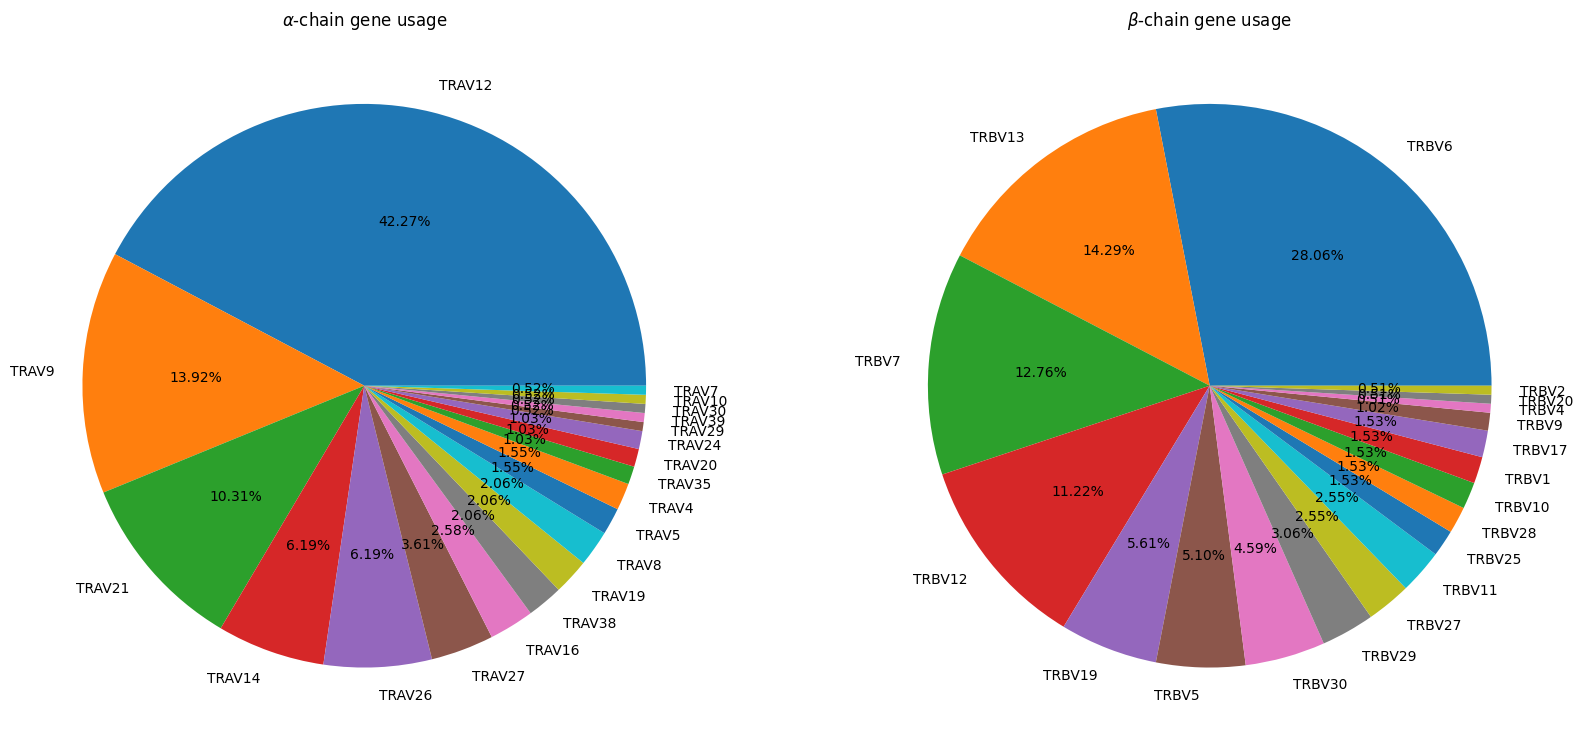

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 20))

apo_holo_summary['alpha_subgroup'].dropna().value_counts().plot.pie(title=r'$\alpha$-chain gene usage',
                                                                    autopct='%1.2f%%',
                                                                    ax=axes[0])
apo_holo_summary['beta_subgroup'].dropna().value_counts().plot.pie(title=r'$\beta$-chain gene usage',
                                                                   autopct='%1.2f%%',
                                                                   ax=axes[1])

for ax in axes:
    ax.set_ylabel('')

In [10]:
counts = apo_holo_summary.value_counts(['alpha_subgroup', 'beta_subgroup'])
labels = sorted(np.concatenate([apo_holo_summary['alpha_subgroup'].dropna().unique(),
                                apo_holo_summary['beta_subgroup'].dropna().unique()]).tolist())

num_labels = len(labels)
adjacency_matrix = np.zeros((num_labels, num_labels), dtype=int)

for i in range(num_labels):
    for j in range(i + 1, num_labels):
        try:
            adjacency_matrix[i, j] = counts[labels[i]][labels[j]]
        except KeyError:
            adjacency_matrix[i, j] = 0

adjacency_matrix = np.maximum(adjacency_matrix, adjacency_matrix.transpose())

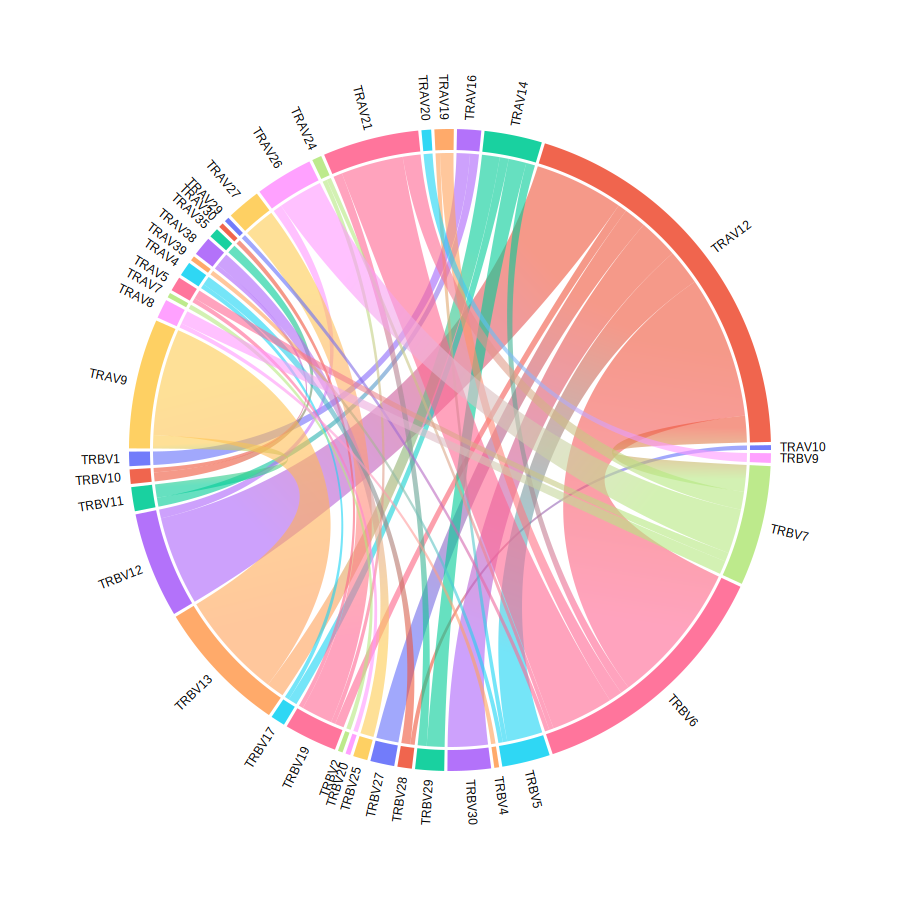

In [11]:
fig = openchord.Chord(adjacency_matrix, labels)

fig.colormap = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
fig.radius = 300
fig.padding = 150
fig.font_size = 12

fig.save_svg('../report/figures/tcr_gene_usage.svg')
fig.show()

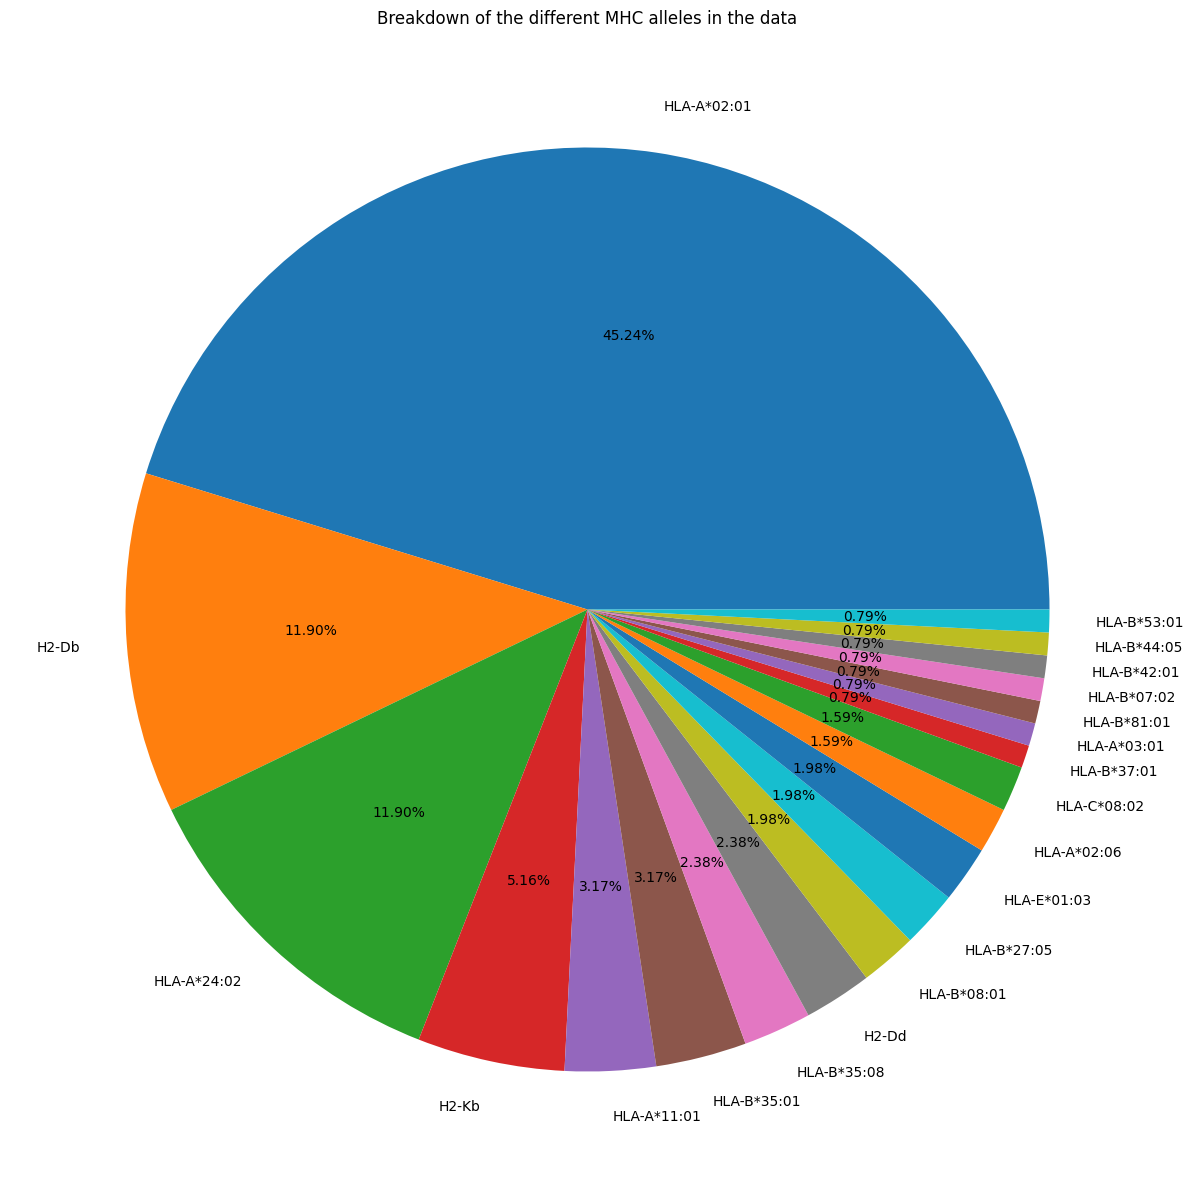

In [12]:
apo_holo_summary['mhc_slug'].dropna().map(mhc_slug_to_code).value_counts().plot.pie(figsize=(15, 15),
                                                                                    autopct='%1.2f%%')
plt.title('Breakdown of the different MHC alleles in the data')
plt.ylabel('')

plt.savefig('../report/figures/mhc_allele_usage.svg')
plt.show()

In [13]:
sequences = apo_holo_summary['peptide_sequence'].dropna().values

In [14]:
with tempfile.TemporaryDirectory() as directory:
    input_file = os.path.join(directory, 'input.fasta')
    output_file = os.path.join(directory, 'output.fasta')

    with open(input_file, 'w') as fh:
        fh.write('\n'.join([f'>{num}\n{seq}\n' for num, seq in enumerate(sequences, 1)]))

    cmd = f'clustalw2 -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA'
    subprocess.run(cmd.split(), check=True, stdout=subprocess.DEVNULL)

    with open(output_file, 'r') as fh:
        aligned_sequences = [line.strip() for line in fh.readlines() if not line.startswith('>')]

/project/koohylab/bmcmaste/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


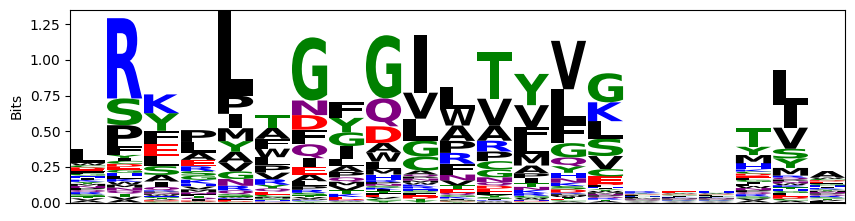

In [15]:
probs = logomaker.alignment_to_matrix(aligned_sequences, to_type='information')
logomaker.Logo(probs, color_scheme='chemistry')

plt.ylabel('Bits')
plt.xticks([])

plt.savefig('../report/figures/peptide_usage.svg')
plt.show()

In [16]:
distance_matrix = np.zeros((sequences.shape[0], sequences.shape[0]), dtype=int)

for i in range(sequences.shape[0]):
    for j in range(i + 1, sequences.shape[0]):
        distance_matrix[i, j] = damerau_levenshtein_distance(sequences[i], sequences[j])

distance_matrix = np.maximum(distance_matrix, distance_matrix.T)

print(f'The average levenshtein distance between all peptide sequences is {np.average(distance_matrix):.2f} edits',
      f'with an standard deviation of {np.std(distance_matrix):.2f} edits.')

The average levenshtein distance between all peptide sequences is 8.14 edits with an standard deviation of 2.00 edits.


In [17]:
CUTOFF_PERCENT = 90

sequence_lengths = np.array([len(seq) for seq in sequences])
grid1, grid2 = np.meshgrid(sequence_lengths, sequence_lengths)

max_lengths = np.maximum(grid1, grid2)
sequence_percent_identities = ((max_lengths - distance_matrix) / max_lengths) * 100

similar_peptides = sequence_percent_identities > CUTOFF_PERCENT



In [18]:
G = nx.Graph()
G.add_nodes_from(range(sequences.shape[0]))

for i in range(1, sequences.shape[0]):
    for j in range(i + 1, sequences.shape[0]):
        if similar_peptides[i, j]:
            G.add_edge(i, j, weight=sequence_percent_identities[i, j] / 100)

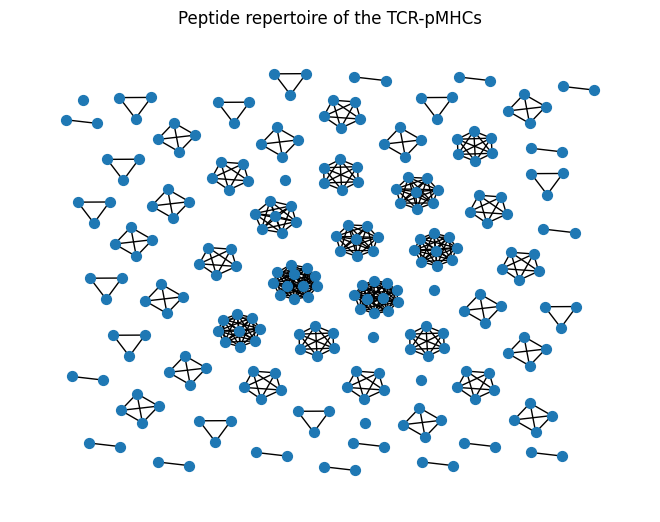

In [19]:
positions = nx.nx_agraph.graphviz_layout(G, prog="neato")

nx.draw(G, positions, node_size=50)

plt.title('Peptide repertoire of the TCR-pMHCs')

plt.savefig('../report/figures/peptide_usage_graph.svg')
plt.show()

# Output strucutres list

In [20]:
pd.set_option('display.max_colwidth', None)

def format_column_name(name: str) -> str:
    name = name.rstrip('_x')
    name = name.replace('_', ' ')
    name = name.title()

    name = ' '.join([word.upper() if word.upper() in ('PDB', 'MHC', 'CDR', 'ID') else word
                     for word in name.split(' ')])

    if name == 'MHC Slug':
        return 'MHC Allele'

    if name[-1].isnumeric():
        name = name[:-1]

    return name

export_df = apo_holo_summary[['pdb_id',
                              'structure_type',
                              'alpha_chain',
                              'beta_chain',
                              'antigen_chain_x',
                              'mhc_chain1_x']].copy()

export_df = export_df.sort_values(['structure_type', 'pdb_id'])
export_df.columns = [format_column_name(col) for col in export_df.columns]

export_df = export_df.fillna('-')
export_df['Structure Type'] = export_df['Structure Type'].map({'tcr': 'TCR', 'pmhc': 'pMHC', 'tcr_pmhc': 'TCR-pMHC'})

with open('../report/apo_holo_pdb_ids.tex', 'w') as fh:
    fh.write(export_df.style.hide(axis='index').to_latex(
        environment='longtable',
        hrules=True,
        caption=('Breakdown of the data used in the analysis of \\textit{apo} and \\textit{holo} '
                 'forms of TCR and pMHC structures. '
                 f'In total there are {num_entries} structures coming from {num_pdb_ids} PDB entries '
                 f'and encompassing {num_unique_tcrs} unique TCRs, {num_unique_mhcs} MHC alleles, '
                 f'and {num_unique_peptides} peptides'),
        label='tab:pdb-ids'))

# Conclusion

Based on the plots and summary statistics in this notebook, it is evident that the dataset is quite biased towards certain TCR genes and MHC Alleles. The peptides are moderately well balanced. This will need to be taken into account in the normalisation and conclusions drawn throughout the rest of the project.